# Rendimiento de Clasificación de Template Matching
Notebook dedicado a estudiar el rendimiento de clasificación de eventos de solar_nu y ruido usando Template Matching

In [1]:
import cv2 as cv
import uproot
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm

import seaborn as sn

In [2]:
def magnitude(vector): 
    #Funcion para calcular radio de eventos al centro del detector
    
    norm = []
    for vec in vector:
    	norm.append(np.linalg.norm(vec))

    return np.array(norm, dtype = np.float32)

# 1 - Extraer datos

In [3]:
# Archivo de Neutrinos Solares
solar_file = uproot.open("/snoplus simulations/solar_nu/split_simu_Analysis_solar_Nue.root")
solar_file.keys()

['T;4', 'T;3', 'pmt;2', 'pmt;1']

In [4]:
#Archivo de Ruido (Talio)
tl_file = uproot.open("/snoplus simulations/talio/split_simu_Analysis_Tl.root")
tl_file.keys()

['T;7', 'T;6', 'pmt;2', 'pmt;1']

In [5]:
solar_data = solar_file['T;4']
tl_data = tl_file['T;7']
pmt_info = solar_file['pmt;1']

## 1.1 - PMT info

In [6]:
pmt_id = np.array(pmt_info['pmt_id'], dtype = np.int16)
pmt_pos_xyz = np.array(pmt_info['pmt_pos_xyz'])
pmt_pos_sph = np.array(pmt_info['pmt_pos_sph'])
pmt_type = np.array(pmt_info['pmt_type'], dtype = np.int16)

## 1.2 - Solar Variables

In [7]:
solar_data.keys()

['evtid',
 'mcID',
 'energy',
 'mc_position',
 'mc_momentum',
 'position',
 'momentum',
 'hit_pmtid',
 'hit_pmttime',
 'hit_residual',
 'hit_type']

Lets cut on number of events, for now

In [8]:
solar_mcID = np.array(solar_data['mcID'], dtype = np.int16)#[:solar_limit]
solar_energy = np.array(solar_data['energy'], dtype = np.float32)#[:solar_limit]
solar_mc_position = np.array(solar_data['mc_position'])#[:solar_limit]   #-> Position Generation
solar_mc_momentum = np.array(solar_data['mc_momentum'])#[:solar_limit]   #-> IMPORTANT: Direction of simulated event
solar_position = np.array(solar_data['position'])#[:solar_limit]        
solar_hit_pmtid = np.array(solar_data['hit_pmtid'], dtype = np.int16)#[:solar_limit]
solar_time_residual = np.array(solar_data['hit_residual'])#[:solar_limit]
solar_hit_type = np.array(solar_data['hit_type'], dtype = np.int16)#[:solar_limit]

## 1.3 - Tálio Variables

In [9]:
tl_mcID = np.array(tl_data['mcID'], dtype = np.int16)#[:tl_limit]
tl_energy = np.array(tl_data['energy'], dtype = np.float32)#[:tl_limit]
tl_mc_position = np.array(tl_data['mc_position'])#[:tl_limit]   #-> Position Generation
tl_mc_momentum = np.array(tl_data['mc_momentum'])#[:tl_limit]   #-> IMPORTANT: Direction of simulated event
tl_position = np.array(tl_data['position'])#[:tl_limit]        
tl_hit_pmtid = np.array(tl_data['hit_pmtid'], dtype = np.int16)#[:tl_limit]
tl_time_residual = np.array(tl_data['hit_residual'])#[:tl_limit]
tl_hit_type = np.array(tl_data['hit_type'], dtype = np.int16)#[:tl_limit]

# 2 - Select Valid Data

Select only hits that verify pmt_type = 1

In [10]:
valid_pmt_id = np.array(np.where(pmt_type == 1)[0]) # PMT valid ID match with index where pmt_type=1

#extract valid indices in data
solar_valid_id_info_i = np.array(np.where(np.in1d(solar_hit_pmtid, valid_pmt_id))[0])
tl_valid_id_info__i = np.array(np.where(np.in1d(tl_hit_pmtid, valid_pmt_id))[0])

#extract coordinates of pmt_type = 1
valid_pmt_xyz = []   #List of valid PMT coordinates (type 1)
for i_dx in valid_pmt_id:
    valid_pmt_xyz.append(pmt_pos_xyz[i_dx])
valid_pmt_xyz = np.array(valid_pmt_xyz)

In [11]:
solar_valid_id_info_i

array([      0,       1,       2, ..., 6223501, 6223502, 6223503],
      dtype=int64)

# 3 - Process Data

Procesamiento de datos (corte en volumen, energia y tiempo), calculo de observable cos(α)

## 3.1 - Ajuste de Procesamiento

El ajuste será aplicado a simulaciones de Tálio y de neutrinos Solares

In [13]:
#params to adjust the cuts--------------------------------------------
#Split Data
split = 10

#energy cut
inf_en_cut = 4
up_en_cut = 6

#time cut
inf_cut = -5
up_cut = 12

#radial cut
radi_cut_method = True   #If true, apply radial cuts given by rad_cut_val to data
rad_cut_val = 5500.0   # Buen valor de corte para observar una identificación efizas de neutrinos solares
#--------------------------------------------------------------------------

### 3.1.1 - Procesamiento de Solares

In [14]:
# Dividir valid_id_info_ev_i en partes
valid_info_ev_split = np.array_split(solar_valid_id_info_i, split)  #---> split(array, parts)

#variables to save: with time residual cuts and radi cut (radi cut is optional, depends on the simulation)
solar_multi_time_residual_cut = []
solar_multi_cos_angle_cut = []
#multi_position_cut = []
solar_multi_mc_momentum_cut = []
solar_multi_mc_ID_cut = []
solar_multi_energy_cut = []

#loop over valid_info_ev_split
for n_loop, split_array in enumerate(valid_info_ev_split):
    print('slipt nº:', n_loop)
    # extract all valid simulated info 
    multi_energy = []
    multi_mc_ID = []
    multi_time_residual = []
    multi_pmt_id_hit = []
    multi_position = []
    #multi_mc_position = []
    multi_mc_momentum = []   
    multi_xyz_hit = []

    for valid_i in split_array:
        multi_energy.append(solar_energy[valid_i])
        multi_mc_ID.append(solar_mcID[valid_i])
        multi_time_residual.append(solar_time_residual[valid_i])
        multi_pmt_id_hit.append(solar_hit_pmtid[valid_i])
        multi_position.append(solar_position[valid_i])
        #multi_mc_position.append(mc_position[valid_i])
        multi_mc_momentum.append(solar_mc_momentum[valid_i])
    multi_energy = np.array(multi_energy)
    multi_time_residual = np.array(multi_time_residual)
    multi_pmt_id_hit = np.array(multi_pmt_id_hit)
    multi_position = np.array(multi_position)

    for id_i in multi_pmt_id_hit:
        multi_xyz_hit.append(pmt_pos_xyz[id_i])
    multi_xyz_hit = np.array(multi_xyz_hit)

    #energy_cut:
    print('In energy cut')
    condition_en_cut = (multi_energy > inf_en_cut) & (multi_energy < up_en_cut)
    
    #variables to extract
    multi_energy = np.extract(condition_en_cut, multi_energy)
    multi_mc_ID = np.extract(condition_en_cut, multi_mc_ID)
    multi_time_residual = np.extract(condition_en_cut, multi_time_residual)
    multi_pmt_id_hit = np.extract(condition_en_cut, multi_pmt_id_hit)

    multi_mc_momentum_en_cut = []
    multi_position_en_cut = []
    for e_dx in np.where(condition_en_cut)[0]:
        multi_mc_momentum_en_cut.append(multi_mc_momentum[e_dx])
        multi_position_en_cut.append(multi_position[e_dx])
    multi_mc_momentum = np.array(multi_mc_momentum_en_cut)
    multi_position = np.array(multi_position_en_cut)
    #freed memory
    multi_mc_momentum_en_cut = None
    multi_position_en_cut = None
            
    #Radial Cut:
    if radi_cut_method == True:
        print('In radi_cut')
        #mc_position_norm = magnitude(multi_mc_position)
        position_norm = magnitude(multi_position)
        max_radi = rad_cut_val
        radi_condition = (position_norm < max_radi)
        index_cut_radi = np.array(np.where(radi_condition)[0])
        #variables to extract
        multi_time_residual = np.extract(radi_condition, multi_time_residual)
        multi_pmt_id_hit = np.extract(radi_condition, multi_pmt_id_hit)
        multi_energy = np.extract(radi_condition, multi_energy)

        multi_mc_ID_radi_cut = []
        multi_mc_momentum_radi_cut = []
        multi_position_radi_cut = []
        multi_xyz_hit_radi_cut = [] 

        for j_dx in index_cut_radi:
            multi_mc_momentum_radi_cut.append(multi_mc_momentum[j_dx])
            multi_position_radi_cut.append(multi_position[j_dx])          #HERE
            multi_mc_ID_radi_cut.append(multi_mc_ID[j_dx])

        for id_i in multi_pmt_id_hit:
            multi_xyz_hit_radi_cut.append(pmt_pos_xyz[id_i])

        multi_mc_ID = multi_mc_ID_radi_cut
        multi_mc_momentum = multi_mc_momentum_radi_cut   #HERE
        multi_position = multi_position_radi_cut
        multi_xyz_hit = multi_xyz_hit_radi_cut
        
        #freed memory
        multi_mc_ID_radi_cut = None
        multi_mc_momentum_radi_cut = None
        multi_position_radi_cut = None
        multi_xyz_hit_radi_cut = None
        radi_condition = None
        index_cut_radi = None
        
    #cos(alpha) calculation -> Uses the definition of scalar product
    multi_cos_angle = []
    N = np.shape(multi_xyz_hit)[0]

    print('computing cos(alpha)')
    for k in range(N):
        #event_direction = np.array([0,0,-1])
        event_direction = multi_mc_momentum[k]
        scalar_product = np.dot(multi_xyz_hit[k], event_direction)
        norm_1 = np.linalg.norm(event_direction)
        norm_2 = np.linalg.norm(multi_xyz_hit[k])
        cos_val = scalar_product/(norm_1*norm_2)
        
        multi_cos_angle.append(cos_val)

    #Time residual cut:
    print('doing time residual cuts')
    for i in np.where((multi_time_residual > inf_cut) & (multi_time_residual < up_cut))[0]:
        solar_multi_time_residual_cut.append(multi_time_residual[i])
        solar_multi_cos_angle_cut.append(multi_cos_angle[i])
        #solar_multi_position_cut.append(multi_position[i])
        solar_multi_mc_momentum_cut.append(multi_mc_momentum[i])
        solar_multi_mc_ID_cut.append(multi_mc_ID[i])
        solar_multi_energy_cut.append(multi_energy[i])

    #freed memory
    multi_cos_angle = None

    #freen memory:    
    multi_mc_ID = None
    multi_time_residual = None
    multi_pmt_id_hit = None
    multi_position = None
    multi_mc_position = None
    multi_mc_momentum = None
    multi_xyz_hit = None
    multi_energy = None

#multi_position_cut = np.array(multi_position_cut)
solar_multi_mc_momentum_cut = np.array(solar_multi_mc_momentum_cut)
solar_multi_mc_ID_cut = np.array(solar_multi_mc_ID_cut, dtype = np.int16)
solar_multi_energy_cut = np.array(solar_multi_energy_cut)

slipt nº: 0
In energy cut
In radi_cut
computing cos(alpha)
doing time residual cuts
slipt nº: 1
In energy cut
In radi_cut
computing cos(alpha)
doing time residual cuts
slipt nº: 2
In energy cut
In radi_cut
computing cos(alpha)
doing time residual cuts
slipt nº: 3
In energy cut
In radi_cut
computing cos(alpha)
doing time residual cuts
slipt nº: 4
In energy cut
In radi_cut
computing cos(alpha)
doing time residual cuts
slipt nº: 5
In energy cut
In radi_cut
computing cos(alpha)
doing time residual cuts
slipt nº: 6
In energy cut
In radi_cut
computing cos(alpha)
doing time residual cuts
slipt nº: 7
In energy cut
In radi_cut
computing cos(alpha)
doing time residual cuts
slipt nº: 8
In energy cut
In radi_cut
computing cos(alpha)
doing time residual cuts
slipt nº: 9
In energy cut
In radi_cut
computing cos(alpha)
doing time residual cuts


### 3.1.2 - Procesamiento de Tálio

In [15]:
# Dividir valid_id_info_ev_i en partes
valid_info_ev_split = np.array_split(tl_valid_id_info__i, split)  #---> split(array, parts)

#variables to save: with time residual cuts and radi cut (radi cut is optional, depends on the simulation)
tl_multi_time_residual_cut = []
tl_multi_cos_angle_cut = []
#multi_position_cut = []
tl_multi_mc_momentum_cut = []
tl_multi_mc_ID_cut = []
tl_multi_energy_cut = []
tl_multi_hit_xyz_cut = []  #save the coordinates of hits to be used to generate the background with (random direction != mc_momentum)

#loop over valid_info_ev_split
for n_loop, split_array in enumerate(valid_info_ev_split):
    print('slipt nº:', n_loop)
    # extract all valid simulated info 
    multi_energy = []
    multi_mc_ID = []
    multi_time_residual = []
    multi_pmt_id_hit = []
    multi_position = []
    #multi_mc_position = []
    multi_mc_momentum = []   
    multi_xyz_hit = []

    for valid_i in split_array:
        multi_energy.append(tl_energy[valid_i])
        multi_mc_ID.append(tl_mcID[valid_i])
        multi_time_residual.append(tl_time_residual[valid_i])
        multi_pmt_id_hit.append(tl_hit_pmtid[valid_i])
        multi_position.append(tl_position[valid_i])
        #multi_mc_position.append(mc_position[valid_i])
        multi_mc_momentum.append(tl_mc_momentum[valid_i])
    multi_energy = np.array(multi_energy)
    multi_time_residual = np.array(multi_time_residual)
    multi_pmt_id_hit = np.array(multi_pmt_id_hit)
    multi_position = np.array(multi_position)

    for id_i in multi_pmt_id_hit:
        multi_xyz_hit.append(pmt_pos_xyz[id_i])
    multi_xyz_hit = np.array(multi_xyz_hit)

    #energy_cut:
    print('In energy cut')
    condition_en_cut = (multi_energy > inf_en_cut) & (multi_energy < up_en_cut)
    
    #variables to extract
    multi_energy = np.extract(condition_en_cut, multi_energy)
    multi_mc_ID = np.extract(condition_en_cut, multi_mc_ID)
    multi_time_residual = np.extract(condition_en_cut, multi_time_residual)
    multi_pmt_id_hit = np.extract(condition_en_cut, multi_pmt_id_hit)

    multi_mc_momentum_en_cut = []
    multi_position_en_cut = []
    for e_dx in np.where(condition_en_cut)[0]:
        multi_mc_momentum_en_cut.append(multi_mc_momentum[e_dx])
        multi_position_en_cut.append(multi_position[e_dx])
    multi_mc_momentum = np.array(multi_mc_momentum_en_cut)
    multi_position = np.array(multi_position_en_cut)
    #freed memory
    multi_mc_momentum_en_cut = None
    multi_position_en_cut = None
            
    #Radial Cut:
    if radi_cut_method == True:
        print('In radi_cut')
        #mc_position_norm = magnitude(multi_mc_position)
        position_norm = magnitude(multi_position)
        max_radi = rad_cut_val
        radi_condition = (position_norm < max_radi)
        index_cut_radi = np.array(np.where(radi_condition)[0])
        #variables to extract
        multi_time_residual = np.extract(radi_condition, multi_time_residual)
        multi_pmt_id_hit = np.extract(radi_condition, multi_pmt_id_hit)
        multi_energy = np.extract(radi_condition, multi_energy)

        multi_mc_ID_radi_cut = []
        multi_mc_momentum_radi_cut = []
        multi_position_radi_cut = []
        multi_xyz_hit_radi_cut = [] 

        for j_dx in index_cut_radi:
            multi_mc_momentum_radi_cut.append(multi_mc_momentum[j_dx])
            multi_position_radi_cut.append(multi_position[j_dx])          #HERE
            multi_mc_ID_radi_cut.append(multi_mc_ID[j_dx])

        for id_i in multi_pmt_id_hit:
            multi_xyz_hit_radi_cut.append(pmt_pos_xyz[id_i])

        multi_mc_ID = multi_mc_ID_radi_cut
        multi_mc_momentum = multi_mc_momentum_radi_cut   #HERE
        multi_position = multi_position_radi_cut
        multi_xyz_hit = multi_xyz_hit_radi_cut
        
        #freed memory
        multi_mc_ID_radi_cut = None
        multi_mc_momentum_radi_cut = None
        multi_position_radi_cut = None
        multi_xyz_hit_radi_cut = None
        radi_condition = None
        index_cut_radi = None
        
    #cos(alpha) calculation -> Uses the definition of scalar product
    multi_cos_angle = []
    N = np.shape(multi_xyz_hit)[0]

    print('computing cos(alpha)')
    for k in range(N):
        #event_direction = np.array([0,0,-1])
        event_direction = multi_mc_momentum[k]
        scalar_product = np.dot(multi_xyz_hit[k], event_direction)
        norm_1 = np.linalg.norm(event_direction)
        norm_2 = np.linalg.norm(multi_xyz_hit[k])
        cos_val = scalar_product/(norm_1*norm_2)
        
        multi_cos_angle.append(cos_val)

    #Time residual cut:
    print('doing time residual cuts')
    for i in np.where((multi_time_residual > inf_cut) & (multi_time_residual < up_cut))[0]:
        tl_multi_time_residual_cut.append(multi_time_residual[i])
        tl_multi_cos_angle_cut.append(multi_cos_angle[i])
        #multi_position_cut.append(multi_position[i])
        tl_multi_mc_momentum_cut.append(multi_mc_momentum[i])
        tl_multi_mc_ID_cut.append(multi_mc_ID[i])
        tl_multi_energy_cut.append(multi_energy[i])
        tl_multi_hit_xyz_cut.append(multi_xyz_hit[i])

    #freed memory
    multi_cos_angle = None

    #freen memory:    
    multi_mc_ID = None
    multi_time_residual = None
    multi_pmt_id_hit = None
    multi_position = None
    multi_mc_position = None
    multi_mc_momentum = None
    multi_xyz_hit = None
    multi_energy = None

#multi_position_cut = np.array(multi_position_cut)
tl_multi_mc_momentum_cut = np.array(tl_multi_mc_momentum_cut)
tl_multi_mc_ID_cut = np.array(tl_multi_mc_ID_cut, dtype = np.int16)
tl_multi_energy_cut = np.array(tl_multi_energy_cut)
tl_multi_hit_xyz_cut = np.array(tl_multi_hit_xyz_cut)

slipt nº: 0
In energy cut
In radi_cut
computing cos(alpha)
doing time residual cuts
slipt nº: 1
In energy cut
In radi_cut
computing cos(alpha)
doing time residual cuts
slipt nº: 2
In energy cut
In radi_cut
computing cos(alpha)
doing time residual cuts
slipt nº: 3
In energy cut
In radi_cut
computing cos(alpha)
doing time residual cuts
slipt nº: 4
In energy cut
In radi_cut
computing cos(alpha)
doing time residual cuts
slipt nº: 5
In energy cut
In radi_cut
computing cos(alpha)
doing time residual cuts
slipt nº: 6
In energy cut
In radi_cut
computing cos(alpha)
doing time residual cuts
slipt nº: 7
In energy cut
In radi_cut
computing cos(alpha)
doing time residual cuts
slipt nº: 8
In energy cut
In radi_cut
computing cos(alpha)
doing time residual cuts
slipt nº: 9
In energy cut
In radi_cut
computing cos(alpha)
doing time residual cuts


# 4 - Escoger ROI

Text(0.5, 1.0, 'ROI Selection - MultiEV - 5 MeV - random(dir)')

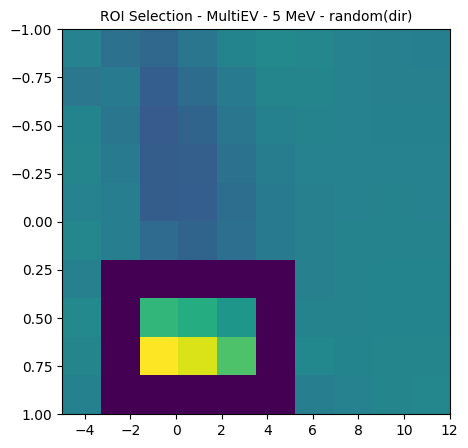

In [16]:
bins = 10

#Load Data
H_norm_multi_ev = np.genfromtxt('Templates/arr_H_Hit_norm_5_10.csv', delimiter = ',')

#select rectangular ROI by positions in Normalized array

#corners
#time res
c1 = 6 #top L (y)
c2 = bins - 1 #bottom L (y)

#cos(α)
c3 = 1 #bottom L (x)
c4 = 5 #bottom R (x)

ROI = H_norm_multi_ev[c1:c2, c3:c4]

#Display region selection
NormHits_multi_ev_display = H_norm_multi_ev.copy()
NormHits_multi_ev_display[c1:c2,c3] = 0.01
NormHits_multi_ev_display[c1:c2, c4] = 0.01
NormHits_multi_ev_display[c2, c3:c4+1] = 0.01
NormHits_multi_ev_display[c1, c3+1:c4] = 0.01

title = 'ROI Selection - MultiEV - 5 MeV - random(dir)'
plt.figure(figsize=(5,5))
plt.imshow(NormHits_multi_ev_display, extent = [-5, 12, 1, -1], aspect = 'auto')
plt.title(title, fontsize = 10)
#plt.savefig('figs/'+title+'_'+str(bins)+'.png', format = 'png')

# 5 - Pattern Matching dentro de ROI

## 5.1 - Solar neutrinos

In [17]:
# Operar sobre eventos individuales y hacer matching dentro de ROI usando la prediccion de los rectagulos de la función cv.matchtemplate().
# Si Esta fuera de ROI -> evento con label = 0, si esta dentro entonces label = 1 

#Ajustes
bins = 10

#Separar mcIDs:
break_i = [0] #List of indices where data change of event ID
N_data = len(solar_multi_mc_ID_cut)
for i in range(N_data-1):
    if solar_multi_mc_ID_cut[i] != solar_multi_mc_ID_cut[i+1]:
        break_i.append(i+1)
break_i = np.array(break_i, dtype = np.int32)

solar_N_evts = len(break_i)

# To construc the confussion Matrix
solar_nu_expected = np.ones(solar_N_evts-1, dtype = np.int8)
solar_nu_predicted = []

#IDs list
IDs = range(solar_N_evts-1)

#To save:
solar_direction = []   #-> Important! To be used in background observavel calculations

for id_i in IDs:
    #init and final of each evID
    i = break_i[id_i]
    f = break_i[id_i + 1]
    
    #select event data
    time_residual_ev = np.array(solar_multi_time_residual_cut[i:f])
    cos_angel_ev = np.array(solar_multi_cos_angle_cut[i:f])
    #energy_ev = np.array(solar_multi_energy_cut[i:f], dtype = np.float16)[0]

    #save direction of event
    solar_direction.append(solar_multi_mc_momentum_cut[i])

    #construct histograms:

    #Δα distribution
    H_ev, xedges, yedges = np.histogram2d(x = cos_angel_ev, y =  time_residual_ev, bins = [bins, bins])

    #Normalization
    sum_hit_ev = np.sum(H_ev,axis=0)
    H_ev_Hit_norm = H_ev/sum_hit_ev

    #Operation between H_norm_multi_ev and H_ev_Hit_norm
    H_ev_boost = H_ev_Hit_norm*H_norm_multi_ev

    #Choose Template for Matching
    H_template = H_norm_multi_ev[6:10, 1:5]  #Values defined by observations on solar_nue notebook for 10bins

    #prepare data for template matching
    #1) Norm transformation
    H_ev_norm = cv.normalize(H_ev_boost, None, alpha = 0, beta = 255, norm_type=cv.NORM_MINMAX)
    H_template_norm = cv.normalize(H_template, None, alpha = 0, beta = 255, norm_type=cv.NORM_MINMAX)
    H_ev_norm2match = cv.normalize(H_ev, None, alpha = 0, beta = 255, norm_type=cv.NORM_MINMAX)
    H_ev_T = H_ev_Hit_norm.astype(np.uint8)

    #2) Rescaling Data
    H_T = H_ev_norm.astype(np.uint8) 
    H_template_T = H_template_norm.astype(np.uint8) 

    #Method 
    method = eval('cv.TM_CCORR')  #Eficaz

    #Apply template matching
    match_res = cv.matchTemplate(H_T, H_template_T, method)
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(match_res)
    
    #Construct Region of identification 
    h, w = np.shape(H_template_T)
    top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)

    #compare vertices of ROI and identified ROI 
    ident_c1 = top_left[1]
    ident_c2 = bottom_right[1]
    ident_c3 = top_left[0]
    ident_c4 = bottom_right[0]

    if (ident_c1 >= c1 and ident_c2 <= bins and ident_c3 >= c3 and ident_c4 <= c4):
        solar_nu_predicted.append(1)
    else:
        solar_nu_predicted.append(0)
        
    #See identified ROI
    #ROI_ident = cv.rectangle(H_ev_norm2match, top_left, bottom_right, color = 255, thickness = 1)
    #plt.imshow(ROI_ident)

solar_direction = np.array(solar_direction)
solar_nu_predicted = np.array(solar_nu_predicted)

C:\Users\joanc\AppData\Local\Temp\ipykernel_17676\1908599841.py:47: RuntimeWarning: invalid value encountered in divide
  H_ev_Hit_norm = H_ev/sum_hit_ev
C:\Users\joanc\AppData\Local\Temp\ipykernel_17676\1908599841.py:60: RuntimeWarning: invalid value encountered in cast
  H_ev_T = H_ev_Hit_norm.astype(np.uint8)
C:\Users\joanc\AppData\Local\Temp\ipykernel_17676\1908599841.py:63: RuntimeWarning: invalid value encountered in cast
  H_T = H_ev_norm.astype(np.uint8)


## 5.2 - Tálio 

In [18]:
#Separar mcIDs:
break_i = [0] #List of indices where data change of event ID
N_data = len(solar_multi_mc_ID_cut)
for i in range(N_data-1):
    if tl_multi_mc_ID_cut[i] != tl_multi_mc_ID_cut[i+1]:
        break_i.append(i+1)
break_i = np.array(break_i, dtype = np.int32)

N_evts = solar_N_evts

# To construc the confussion Matrix
tl_expected = np.zeros(N_evts-1, dtype = np.int8)
tl_predicted = []

#IDs list
IDs = range(N_evts-1)
#IDs = [5]

#to save
tl_direction = [] #Talio direction

for id_i in IDs:
    #init and final of each evID
    i = break_i[id_i]
    f = break_i[id_i + 1]
    
    #select event data
    time_residual_ev = np.array(tl_multi_time_residual_cut[i:f])
    #cos_angel_ev = np.array(tl_multi_cos_angle_cut[i:f])
    #energy_ev = np.array(solar_multi_energy_cut[i:f], dtype = np.float16)[0]
    hit_xyz_ev = np.array(tl_multi_hit_xyz_cut[i:f])

    tl_direction.append(tl_multi_mc_momentum_cut[i])
    
    pse_momentum = solar_direction[id_i]
    pse_cos_ev = []
    N = np.shape(hit_xyz_ev)[0]
    #compute fake cos(α)
    for k_dx in range(N):
        scalar_prd = np.dot(hit_xyz_ev[k_dx], pse_momentum)
        norm_1 = np.linalg.norm(pse_momentum)
        norm_2 = np.linalg.norm(hit_xyz_ev[k_dx])
        cos_val = scalar_prd/(norm_1*norm_2) 
        pse_cos_ev.append(cos_val)

    #construct histograms:

    #Δα distribution
    H_ev, xedges, yedges = np.histogram2d(x = pse_cos_ev, y =  time_residual_ev, bins = [bins, bins])

    #Normalization
    sum_hit_ev = np.sum(H_ev,axis=0)
    H_ev_Hit_norm = H_ev/sum_hit_ev

    #Operation between H_norm_multi_ev and H_ev_Hit_norm
    H_ev_boost = H_ev_Hit_norm*H_norm_multi_ev

    #Choose Template for Matching
    H_template = H_norm_multi_ev[6:10, 1:5]  #Values defined by observations on solar_nue notebook for 10bins

    #prepare data for template matching
    #1) Norm transformation
    H_ev_norm = cv.normalize(H_ev_boost, None, alpha = 0, beta = 255, norm_type=cv.NORM_MINMAX)
    H_template_norm = cv.normalize(H_template, None, alpha = 0, beta = 255, norm_type=cv.NORM_MINMAX)
    H_ev_norm2match = cv.normalize(H_ev, None, alpha = 0, beta = 255, norm_type=cv.NORM_MINMAX)
    H_ev_T = H_ev_Hit_norm.astype(np.uint8)

    #2) Rescaling Data
    H_T = H_ev_norm.astype(np.uint8) 
    H_template_T = H_template_norm.astype(np.uint8) 

    #Method 
    method = eval('cv.TM_CCORR')  #Eficaz

    #Apply template matching
    match_res = cv.matchTemplate(H_T, H_template_T, method)
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(match_res)
    
    #Construct Region of identification 
    h, w = np.shape(H_template_T)
    top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)

    #compare vertices of ROI and identified ROI 
    ident_c1 = top_left[1]
    ident_c2 = bottom_right[1]
    ident_c3 = top_left[0]
    ident_c4 = bottom_right[0]

    if (ident_c1 >= c1 and ident_c2 <= bins and ident_c3 >= c3 and ident_c4 <= c4):
        tl_predicted.append(1)
    else:
        tl_predicted.append(0)
        
    #See identified ROI
    #ROI_ident = cv.rectangle(H_ev_norm2match, top_left, bottom_right, color = 255, thickness = 1)
    #plt.imshow(ROI_ident)

tl_predicted = np.array(tl_predicted)
tl_direction = np.array(tl_direction)

C:\Users\joanc\AppData\Local\Temp\ipykernel_17676\120065718.py:53: RuntimeWarning: invalid value encountered in divide
  H_ev_Hit_norm = H_ev/sum_hit_ev
C:\Users\joanc\AppData\Local\Temp\ipykernel_17676\120065718.py:66: RuntimeWarning: invalid value encountered in cast
  H_ev_T = H_ev_Hit_norm.astype(np.uint8)
C:\Users\joanc\AppData\Local\Temp\ipykernel_17676\120065718.py:69: RuntimeWarning: invalid value encountered in cast
  H_T = H_ev_norm.astype(np.uint8)


In [24]:
tl_expected

array([0, 0, 0, ..., 0, 0, 0], dtype=int8)

In [23]:
solar_nu_predicted

array([0, 0, 0, ..., 1, 0, 0])

## 5.3 - Construcción de Matriz de Confusión

Necesitamos extraer las predicciones para Tálio y para Neutrinos solares y concatenar!

In [26]:
expected = np.concatenate((solar_nu_expected,tl_expected))
predicted = np.concatenate((solar_nu_predicted,tl_predicted))

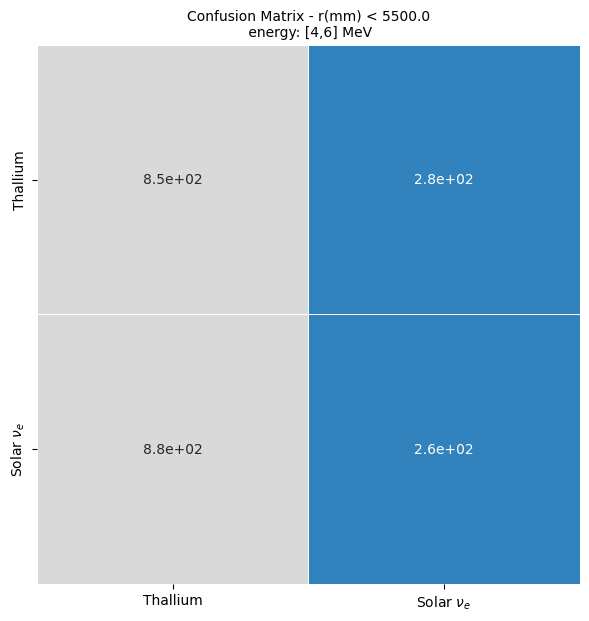

In [61]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(expected, predicted)

title = 'Confusion Matrix - r(mm) < ' +str(rad_cut_val) + '\n energy: [4,6] MeV'

plt.figure(figsize =(7,7))
sn.heatmap(confusion_matrix, annot = True, cbar = False, xticklabels = ['Thallium' ,'Solar $ν_e$'], yticklabels = ['Thallium' ,'Solar $ν_e$'], cmap = cm.tab20c,  linewidth=.5)
plt.title(title, fontsize = 10)
plt.savefig('figs/Confusion Matrix_'+ str(rad_cut_val) + '_' + str(bins) +'.png', format = 'png',  bbox_inches = 'tight')